Take away.  A lot can be done with just pandas.

The ubiquity of data means that combining datasets must scale better.

# ✋✋✋✋✋✋✋✋

I'm [Tony Fast]().ipynb_checkpoints/  I organize [PyData Atlanta]() and the [Jupyter User Group]().  I am currently interested in composing human readable programs
using notebooks.

I'm going to tell you a little bit about myself in data.  Then we will dissect my approach.

In [250]:
    from .statements import get as request
    import typing as t
    import pandas, asyncio, ibis.sql.sqlite
    from toolz.curried import *
    %matplotlib inline
    import datetime

    from .statements import get as request
    import typing as t
    import pandas, asyncio, ibis.sql.sqlite
    from toolz.curried import *
    %matplotlib inline
    import datetime

# Accessing data.

Pandas has a bunch of read methods that you should fully take advantage of.

In [13]:
    pipe(pandas, dir, filter(flip(str.startswith)('read_')), list, pandas.DataFrame).T

    pipe(pandas, dir, filter(flip(str.startswith)('read_')), list, pandas.DataFrame).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,read_clipboard,read_csv,read_excel,read_feather,read_fwf,read_gbq,read_hdf,read_html,read_json,read_msgpack,read_parquet,read_pickle,read_sas,read_sql,read_sql_query,read_sql_table,read_stata,read_table


In [14]:
    frames = pandas.read_html("https://en.wikipedia.org/wiki/List_of_physical_quantities")
    f"There are __{len(frames)}__ tables in this webpage."

    frames = pandas.read_html("https://en.wikipedia.org/wiki/List_of_physical_quantities")
    f"There are __{len(frames)}__ tables in this webpage."

There are __2__ tables in this webpage.

## Caching requests

Caching our requests assures that our data remains local and we can work with out the internet.

In [15]:
    import requests_cache; requests_cache.install_cache('idiomatic_pandas')

    import requests_cache; requests_cache.install_cache('idiomatic_pandas')

In [16]:
    request??

    request??

Signature: request(url, params={}, headers={}) -> Union[pandas.core.series.Series, pandas.core.frame.DataFrame]
Docstring: `get` is asynchronous allowing data to be downloaded concurrently.
Source:   
async def get(url, params={}, headers={}) -> Union[pandas.Series, pandas.DataFrame]: 
    result = requests.get(url, params={
        **params, 'access_token': os.environ.get('gh')
    }, headers=headers).content
    try:
        return pandas.read_json(result)
    except ValueError: 
        return pandas.read_json(result, typ=pandas.Series)
File:      c:\users\deathbeds\idiomatic_pandas\idiomatic_pandas\statements.ipynb
Type:      function


> Sometimes I use Python type annotations to indicate the input and output values of the functions.

In [17]:
    username = 'tonyfast'

    username = 'tonyfast'

In [18]:
    info = await request(f"https://api.github.com/users/%s"%username); info.to_frame()

    info = await request(f"https://api.github.com/users/%s"%username); info.to_frame()

,0
login,tonyfast
id,4236275
node_id,MDQ6VXNlcjQyMzYyNzU=
avatar_url,https://avatars3.githubusercontent.com/u/42362...
gravatar_id,
url,https://api.github.com/users/tonyfast
html_url,https://github.com/tonyfast
followers_url,https://api.github.com/users/tonyfast/followers
following_url,https://api.github.com/users/tonyfast/followin...
gists_url,https://api.github.com/users/tonyfast/gists{/g...


In [6]:
    f"![]({info.avatar_url})"

    f"![]({info.avatar_url})"

![](https://avatars3.githubusercontent.com/u/4236275?v=4)

## Some utitlity statements.

Accessing historical data in github requires pagination. https://developer.github.com/v3/guides/traversing-with-pagination/

`paginate` appends `"?page=%i"` to the end of our Github API requests.

In [19]:
    def paginate(url: str, slice: slice=slice(1,3)) -> t.Generator:
        return (f"{url}?page={page}" for page in range(slice.start, slice.stop+1))

    def paginate(url: str, slice: slice=slice(1,3)) -> t.Generator:
        return (f"{url}?page={page}" for page in range(slice.start, slice.stop+1))

I don't have `datetime` for composing timestamps so I use `pandas.to_datetime`

In [20]:
    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

`pandas.to_timedelta` helps with Δt.

In [24]:
    pandas.to_timedelta('1 days 10 seconds')

    pandas.to_timedelta('1 days 10 seconds')

Timedelta('1 days 00:00:10')

and the difference between timestamps returns a time delta.

In [38]:
    Δt = pandas.Series([info.created_at, info.updated_at]).pipe(pandas.to_datetime).diff().dropna(); Δt

    Δt = pandas.Series([info.created_at, info.updated_at]).pipe(pandas.to_datetime).diff().dropna(); Δt

1   1987 days 02:19:37
dtype: timedelta64[ns]

## Let's talk about me

In [49]:
    repos = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.repos_url, slice(1, info.public_repos//30+1))))
    ).set_index('id').pipe(timify)
    f"""I have __{len(repos)}__ repositories associated with my account after __>{Δt[1].days//365}__ years."""

    repos = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.repos_url, slice(1, info.public_repos//30+1))))
    ).set_index('id').pipe(timify)
    f"""I have __{len(repos)}__ repositories associated with my account after __>{Δt[1].days//365}__ years."""

I have __156__ repositories associated with my account after __>5__ years.

In [55]:
    events = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.events_url.format(**{'/privacy': ''}), slice(1, 10))))
    ).set_index('id').pipe(timify)

    events = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.events_url.format(**{'/privacy': ''}), slice(1, 10))))
    ).set_index('id').pipe(timify)

>  __🐼 + `async` + Caching = 💪__

In [50]:
    gists = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.gists_url.format(**{'/gist_id': ''}), slice(1, info.public_gists//30+1))
        ))
    ).set_index('id').pipe(timify)
    f"""I've made __{len(gists)}__ gists during that time."""

    gists = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.gists_url.format(**{'/gist_id': ''}), slice(1, info.public_gists//30+1))
        ))
    ).set_index('id').pipe(timify)
    f"""I've made __{len(gists)}__ gists during that time."""

I've made __513__ gists during that time.

In [52]:
    stars = pandas.concat(
        await asyncio.gather(*map(
            partial(request, headers={
                'Accept': "application/vnd.github.v3.star+json"
            }), paginate(
                info.starred_url.format(**{'/owner': '', '/repo': ''}), slice(1, 700//30+1))
        ))
    ).pipe(
        lambda df: pandas.concat([df.repo.apply(pandas.Series), df.starred_at], axis=1)
    ).pipe(timify).set_index('id')
    f"""I've starred __{len(stars)}__ repositories, too."""

    stars = pandas.concat(
        await asyncio.gather(*map(
            partial(request, headers={
                'Accept': "application/vnd.github.v3.star+json"
            }), paginate(
                info.starred_url.format(**{'/owner': '', '/repo': ''}), slice(1, 700//30+1))
        ))
    ).pipe(
        lambda df: pandas.concat([df.repo.apply(pandas.Series), df.starred_at], axis=1)
    ).pipe(timify).set_index('id')
    f"""I've starred __{len(stars)}__ repositories, too."""

I've starred __700__ repositories, too.

In [161]:
    pandas.Index.to_series, pandas.Index.to_frame, pandas.Index.to_native_types

    pandas.Index.to_series, pandas.Index.to_frame, pandas.Index.to_native_types

(<function pandas.core.indexes.base.Index.to_series(self, index=None, name=None)>,
 <function pandas.core.indexes.base.Index.to_frame(self, index=True)>,
 <function pandas.core.indexes.base.Index.to_native_types(self, slicer=None, **kwargs)>)

    events.type.value_counts().plot.pie()
    f"""A look at __{username}'s__ last __300__ events.'"""

A look at __tonyfast's__ last __300__ events.'

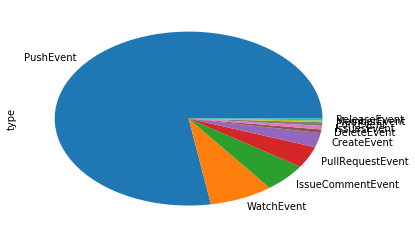

In [67]:
    events.type.value_counts().plot.pie()
    f"""A look at __{username}'s__ last __300__ events.'"""

In [75]:
    from matplotlib_venn import *; from toolz.curried.operator import *

    from matplotlib_venn import *; from toolz.curried.operator import *

    pipe((repos, gists, stars), map(attrgetter('columns')), map(set), list, 
         partial(venn3_unweighted, set_labels=('repos', 'gists', 'stars')))

    intersections = set(repos.columns).intersection(gists.columns).intersection(stars.columns)
    f"The __{len(intersections)}__ overlapping columns are: __{', '.join(intersections)}__"

The __10__ overlapping columns are: __updated_at, url, created_at, description, forks_url, html_url, comments_url, owner, node_id, commits_url__

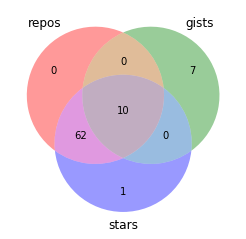

In [95]:
    pipe((repos, gists, stars), map(attrgetter('columns')), map(set), list, 
         partial(venn3_unweighted, set_labels=('repos', 'gists', 'stars')))

    intersections = set(repos.columns).intersection(gists.columns).intersection(stars.columns)
    f"The __{len(intersections)}__ overlapping columns are: __{', '.join(intersections)}__"

## Aggregations

`pandas.DataFrame.groupby` & `pandas.DataFrame.rolling` aggreations

In [156]:
    monthly_actions = repos.set_index('created_at')[[]].join(
        gists.set_index('created_at')[[]]
    ).join(
        stars.set_index('created_at')[[]]
    ).sort_index().index.to_frame().groupby(
        pandas.Grouper(freq='M')
    ).count()['created_at'].rename('created')

    monthly_actions = repos.set_index('created_at')[[]].join(
        gists.set_index('created_at')[[]]
    ).join(
        stars.set_index('created_at')[[]]
    ).sort_index().index.to_frame().groupby(
        pandas.Grouper(freq='M')
    ).count()['created_at'].rename('created')

    ax = monthly_actions.plot(title='Events per month', legend=True)

    monthly_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True, grid=True)

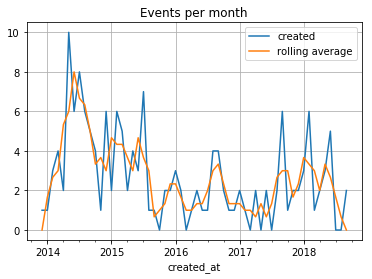

In [155]:
    ax = monthly_actions.plot(title='Events per month', legend=True)
    monthly_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True, grid=True)

    this_years_actions = monthly_actions[monthly_actions.index > pandas.to_datetime('2018-04-01')]
    ax = this_years_actions.plot(title='Events per month', legend=True, figsize=(24, 8), grid=True)
    this_years_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True)
    events.set_index('created_at').index.to_frame().groupby(
        pandas.Grouper(freq='1D')
    ).count()['created_at'].rename('minor events').plot(ax=ax, legend=True, grid=True)

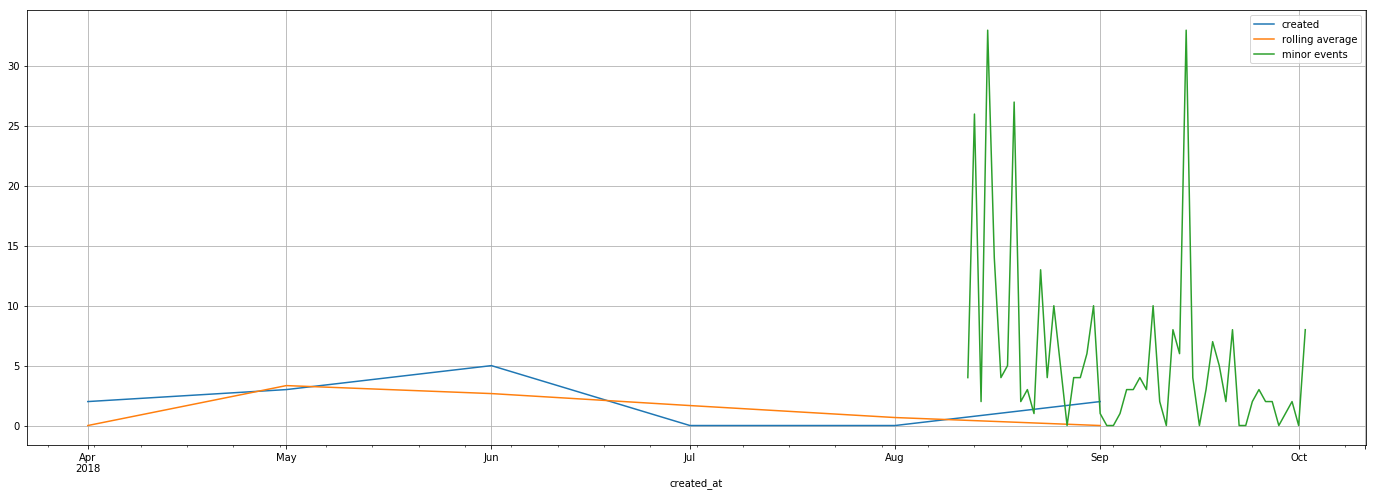

In [154]:
    this_years_actions = monthly_actions[monthly_actions.index > pandas.to_datetime('2018-04-01')]
    ax = this_years_actions.plot(title='Events per month', legend=True, figsize=(24, 8), grid=True)
    this_years_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True)
    events.set_index('created_at').index.to_frame().groupby(
        pandas.Grouper(freq='1D')
    ).count()['created_at'].rename('minor events').plot(ax=ax, legend=True, grid=True)

In [168]:
    gist = gists.files.apply(pandas.Series).stack(level=0).apply(pandas.Series).join(gists).reset_index(-1, drop=True)

    gist = gists.files.apply(pandas.Series).stack(level=0).apply(pandas.Series).join(gists).reset_index(-1, drop=True)

In [188]:
    import matplotlib

    import matplotlib

Method chaingm

    languages = gist.set_index('created_at').language.groupby(pandas.Grouper(freq='1Y')).value_counts().unstack().pipe(
        lambda df: languages.set_index(df.index.year))
    subplots = pandas.Series(matplotlib.pyplot.subplots(1, len(languages), figsize=(24, 5))[1], languages.index)
    
    languages.apply(
        lambda s: s.dropna().plot.bar(title=s.name, ax=subplots.loc[s.name], grid=True), axis=1)
    matplotlib.pyplot.show()
    gist.language.value_counts().plot.bar(title='total', grid=True, figsize=(24, 5));

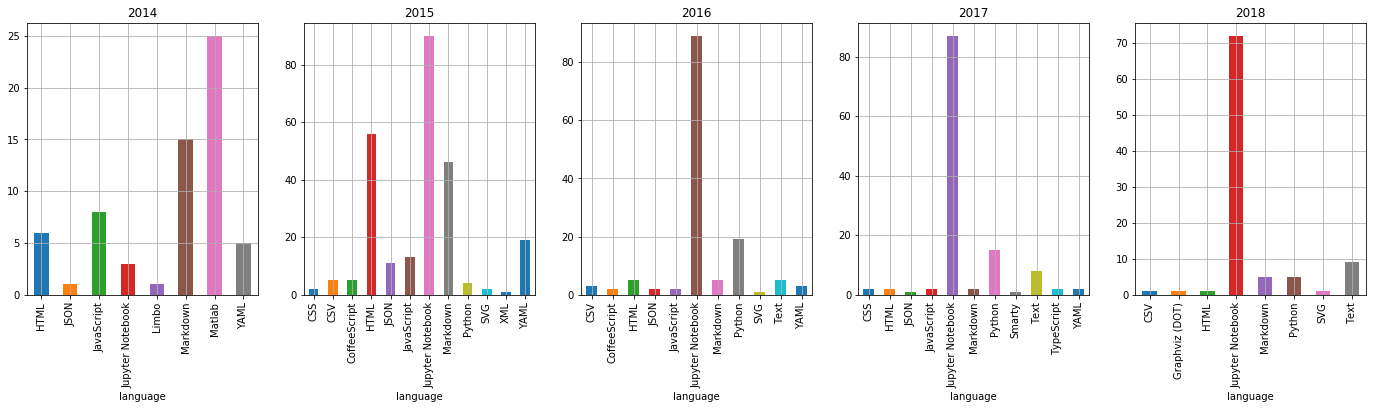

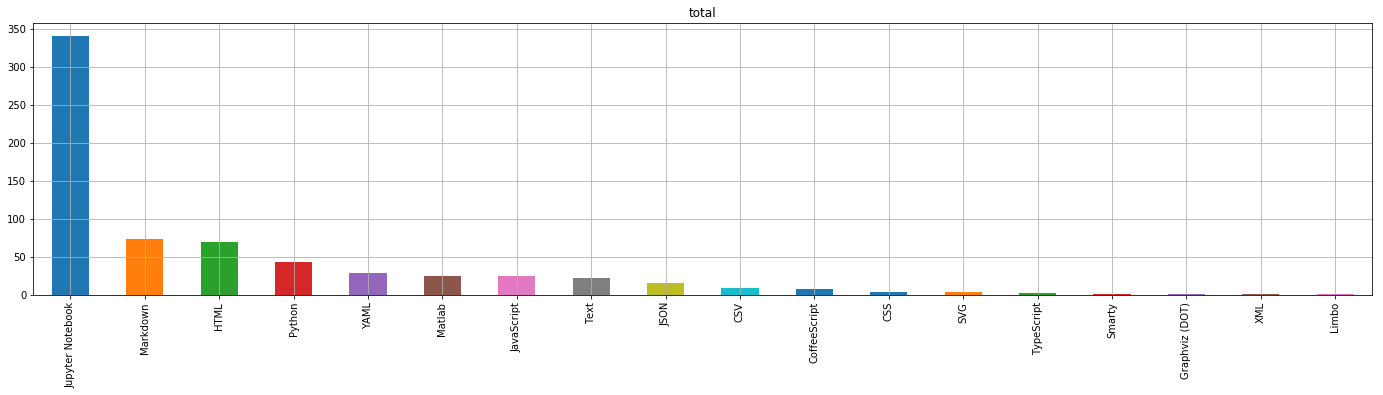

In [366]:
    languages = gist.set_index('created_at').language.groupby(pandas.Grouper(freq='1Y')).value_counts().unstack().pipe(
        lambda df: languages.set_index(df.index.year))
    subplots = pandas.Series(matplotlib.pyplot.subplots(1, len(languages), figsize=(24, 5))[1], languages.index)
    
    languages.apply(
        lambda s: s.dropna().plot.bar(title=s.name, ax=subplots.loc[s.name], grid=True), axis=1)
    matplotlib.pyplot.show()
    gist.language.value_counts().plot.bar(title='total', grid=True, figsize=(24, 5));

    from . import readme as ˣ

In [252]:
    import pandas; "Explicit is better than implicit.";

    import pandas; "Explicit is better than implicit.";

In [253]:
    import os; os.environ.get('gh'); params = {'access_token': os.environ.get('gh')}

    import os; os.environ.get('gh'); params = {'access_token': os.environ.get('gh')}

In [4]:
    gh = f"https://api.github.com/users/%s"

    gh = f"https://api.github.com/users/%s"

In [5]:
    info = pandas.read_json(gh%'tonyfast', typ=pandas.Series)

    info = pandas.read_json(gh%'tonyfast', typ=pandas.Series)

In [254]:
    import ast
    import nbconvert

In [361]:
    attributes = pandas.Series()
    class FindAttributes(ast.NodeVisitor):
        def visit_Attribute(self, node):   self.attributes[-1].append(node.attr) or super().generic_visit(node)
                        
        def visit_Name(self, node):  
            value = globals().get(node.id, None)
            self.attributes[-1].append(
                type(value).__name__ if isinstance(value, (pandas.DataFrame, pandas.Series)) else node.id
            ) or super().generic_visit(node)

        def __call__(self, str):
            self.attributes = list()
            for body in ast.parse(str).body:
                self.attributes.append([])
                self.visit(body)
                self.attributes[-1] = ', '.join(reversed(self.attributes[-1]))
            return pandas.Series(self.attributes).pipe(lambda s: s[s.apply(bool)])
    actions = FindAttributes()(nbconvert.get_exporter('python')().from_filename(filename='intro.ipynb')[0].replace('await ', ''))

    attributes = pandas.Series()
    class FindAttributes(ast.NodeVisitor):
        def visit_Attribute(self, node):   self.attributes[-1].append(node.attr) or super().generic_visit(node)
                        
        def visit_Name(self, node):  
            value = globals().get(node.id, None)
            self.attributes[-1].append(
                type(value).__name__ if isinstance(value, (pandas.DataFrame, pandas.Series)) else node.id
            ) or super().generic_visit(node)

        def __call__(self, str):
            self.attributes = list()
            for body in ast.parse(str).body:
                self.attributes.append([])
                self.visit(body)
                self.attributes[-1] = ', '.join(reversed(self.attributes[-1]))
            return pandas.Series(self.attributes).pipe(lambda s: s[s.apply(bool)])
    actions = FindAttributes()(nbconvert.get_exporter('python')().from_filename(filename='intro.ipynb')[0].replace('await ', ''))

A back of the envelope use of attributes.

In [362]:
    actions.str.split(
        ',', expand=True
    ).stack().str.strip().value_counts().T

    actions.str.split(
        ',', expand=True
    ).stack().str.strip().value_counts().T

Series              41
pandas              30
DataFrame           30
df                  11
set_index           11
str                 11
pipe                10
self                 8
plot                 8
slice                8
apply                7
attributes           7
at                   6
len                  6
map                  6
s                    5
columns              5
ax                   5
join                 5
to_frame             5
node                 5
request              5
concat               5
index                5
to_datetime          4
timify               4
format               4
gather               4
rename               4
T                    4
                    ..
reset_index          1
range                1
get_exporter         1
to_timedelta         1
filter               1
files                1
start                1
visit                1
subplots             1
sort_index           1
attrgetter           1
repo                 1
isinstance 

In [363]:
    pandas.DataFrame.applymap, pandas.DataFrame.apply, pandas.DataFrame.pipe
    pandas.Series.apply, pandas.Series.pipe
    pandas.Index.map, pandas.Index.to_series, pandas.Index.to_frame

    pandas.DataFrame.applymap, pandas.DataFrame.apply, pandas.DataFrame.pipe
    pandas.Series.apply, pandas.Series.pipe
    pandas.Index.map, pandas.Index.to_series, pandas.Index.to_frame

(<function pandas.core.indexes.base.Index.map(self, mapper, na_action=None)>,
 <function pandas.core.indexes.base.Index.to_series(self, index=None, name=None)>,
 <function pandas.core.indexes.base.Index.to_frame(self, index=True)>)

In [367]:
    df = pandas.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
                        'B': {0: 1, 1: 3, 2: 5},
                        'C': {0: 2, 1: 4, 2: 6}})
    pandas.melt(df, id_vars=['A'], value_vars=['B'])

    df = pandas.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
                        'B': {0: 1, 1: 3, 2: 5},
                        'C': {0: 2, 1: 4, 2: 6}})
    pandas.melt(df, id_vars=['A'], value_vars=['B'])

,A,variable,value
0,a,B,1
1,b,B,3
2,c,B,5


In [371]:
    df.set_index('A').unstack()

    df.set_index('A').unstack()

   A
B  a    1
   b    3
   c    5
C  a    2
   b    4
   c    6
dtype: int64